In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from visualization import TrainingVisualizer
import torch.nn.functional as F

In [2]:
import torch
import matplotlib.pyplot as plt

# 定义可视化函数
def visualize_tensor(tensor, indices, title=""):
    fig, axes = plt.subplots(1, len(indices), figsize=(9, 3))
    if len(indices) == 1:
        axes = [axes]  # 将单个AxesSubplot对象包装成一个列表
    for ax, idx in zip(axes, indices):
        image = tensor[idx, 0].detach().cpu().numpy()
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Image {idx+1}")
        ax.axis('off')
    fig.suptitle(title)
    plt.show()

In [3]:
# 数据预处理和加载
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
def spherical_to_cartesian(radius, theta, phi):
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    return x, y, z

def get_position_encoding_matrix(rows, cols):
    position_encoding_matrix = np.zeros((rows, cols, 3))
    radius = 1

    for i in range(rows):
        for j in range(cols):
            theta = (j / (cols - 1)) * (np.pi / 2)
            phi = (i / (rows - 1)) * (np.pi / 2)
            x, y, z = spherical_to_cartesian(radius, theta, phi)
            position_encoding_matrix[i, j] = [x, y, z]

    return position_encoding_matrix

position_encoding_matrix = get_position_encoding_matrix(28, 28)
position_encoding_matrix = torch.tensor(position_encoding_matrix, dtype=torch.float32).view(28 * 28, 3)

In [5]:
position_encoding_matrix.unsqueeze(0).unsqueeze(0).shape, position_encoding_matrix.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1, 1).shape

(torch.Size([1, 1, 784, 3]), torch.Size([256, 1, 784, 3]))

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
class LeNetWithPositionEncoding(nn.Module):
    def __init__(self, use_position_encoding=True):
        super(LeNetWithPositionEncoding, self).__init__()
        self.use_position_encoding = use_position_encoding

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        if self.use_position_encoding:
            self.position_fc1 = nn.Linear(3, 128)
            self.position_fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batch_size = x.size(0)
        
        # 提取并可视化第一张图片
        # visualize_tensor(x, [0, 1, 2], title="Original Image")
        
        # 先处理位置信息
        if self.use_position_encoding:
            position_encoding_matrix_batch = position_encoding_matrix.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1, 1) # (batch_size, 1, 28*28, 3)
            position_encoding_matrix_batch = position_encoding_matrix_batch.to(device)
            position_features = F.relu(self.position_fc1(position_encoding_matrix_batch)) # 得到(batch_size, 1, 28*28, 128)的矩阵
            position_features = self.position_fc2(position_features) # 得到(batch_size, 1, 28*28, 1)的矩阵
            position_features = position_features.view(batch_size, 1, 28, 28) # 得到(batch_size, 1, 28, 28)的矩阵
            x = torch.mul(x, position_features)

        # 可视化逐元素相乘后的结果
        # visualize_tensor(x, [0, 1, 2], title="Element-wise Multiplication Result")

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(batch_size, -1)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [14]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [15]:
# 初始化模型、损失函数和优化器
model_wPE = LeNetWithPositionEncoding()
model_woPE = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer_wPE = optim.Adam(model_wPE.parameters(), lr=0.001)
optimizer_woPE = optim.Adam(model_woPE.parameters(), lr=0.001)

In [16]:
model_wPE.to(device)
model_woPE.to(device)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [17]:
# 训练和测试模型
def train(model, device, train_loader, optimizer, criterion, epoch, visualizer):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct / len(train_loader.dataset)
    
    # visualizer.add(epoch, (avg_train_loss, train_accuracy))
    return epoch, avg_train_loss, train_accuracy

def test(model, device, test_loader, criterion, epoch, visualizer):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)

    return epoch, test_accuracy

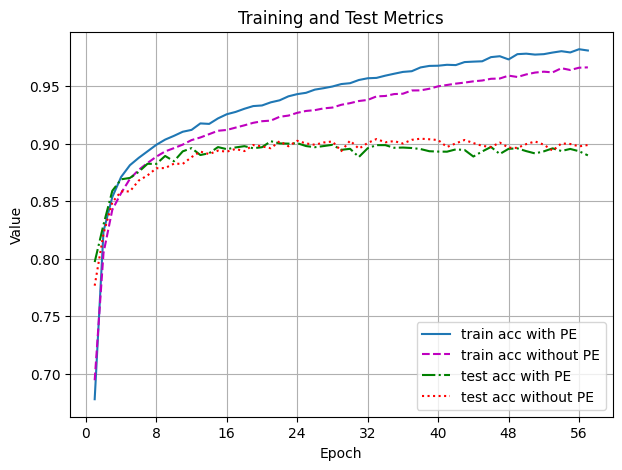

In [ ]:
# 初始化 TrainingVisualizer
visualizer = TrainingVisualizer(xlabel='Epoch', ylabel='Value', title='Training and Test Metrics',
                                legend=['train acc with PE', 'train acc without PE', "test acc with PE", "test acc without PE"])

# 训练和测试模型
for epoch in range(1, 101):
    epoch, avg_train_loss_wPE, train_accuracy_wPE = train(model_wPE, device, train_loader, optimizer_wPE, criterion, epoch, visualizer)
    epoch, test_accuracy_wPE = test(model_wPE, device, test_loader, criterion, epoch, visualizer)
    
    epoch, avg_train_loss_woPE, train_accuracy_woPE = train(model_woPE, device, train_loader, optimizer_woPE, criterion, epoch, visualizer)
    epoch, test_accuracy_woPE = test(model_woPE, device, test_loader, criterion, epoch, visualizer)
    
    visualizer.add(epoch, (train_accuracy_wPE, train_accuracy_woPE, test_accuracy_wPE, test_accuracy_woPE))